# Calculating the Kullback–Leibler (KL) divergence profile

This workbook is a contribution towards the project to include a distortion index segregation statistic within the PySAL library, as part of Google Summer of Code. The distortion index segregation statistic draws its main inspiration from Olteanu et al (2019) paper, "[Segregation through the multiscalar lens](https://www.pnas.org/content/116/25/12250)".

Read on to see an example run-through of code used to calculate a [Kullback–Leibler (KL) divergence profile](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) - with the code ran with example data from the 2011 UK census from Leicester, a city in the East Midlands of England.

The data used can be found on my [Example Data - Leicester, UK](https://github.com/noahbouchier/GSoC-PySAL-21/tree/master/Example%20Data%20-%20Leicester%2C%20UK) repository.

The workbook is separated into a sequence of steps:

- Step 1 deals with reading in the data from Leicester.

A considerable amount of steps 2 and 3 use code from the work of [Cécile de Bézenac](https://www.turing.ac.uk/people/doctoral-students/cecile-de-bezenac), and which can be found within the Python files of this [segregation_index GitHub repository](https://github.com/ceciledebezenac/segregation_index/tree/master/divergence).

- Step 2 creates a population matrix - which is an easier format for the data being analysed to be stored in. This makes subsequent analysis more efficient (quicker to run).

- Step 3 begins the calculation of the KL divergence profile by creating the objects used in it's calculation. Using the formula taken from the Olteanu et al (2019) paper (see below), these objects are labelled *q* and *r*.

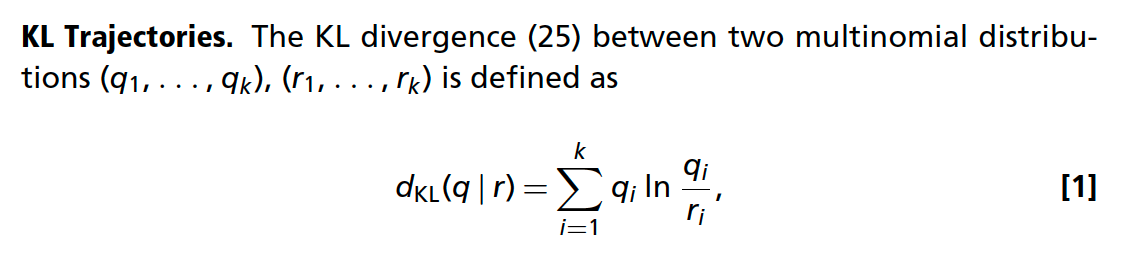

- Step 4 utilises the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function to calculate the KL divergence profile (which is also referred to as relative entropy), having used the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) to order geographical units with repect to their distance from one another.

In [46]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial
from scipy.spatial import distance_matrix
import math

## Step 1 - Read in the data

First things first is to read the data into the working environment.

The data is a shapefile, called **leicester_ethnicity** (available from my [Example Data - Leicester, UK](https://github.com/noahbouchier/GSoC-PySAL-21/tree/master/Example%20Data%20-%20Leicester%2C%20UK) repository) - this is:
* An object containing demographic information and geometry (boundary data) of Leicester, UK
* Demographic information on ethnic identification of residents - at Output Area (OA) level
* Comprised of data from the 2011 UK census - follow links to: [explanation](https://www.ons.gov.uk/peoplepopulationandcommunity/culturalidentity/ethnicity/articles/ethnicityandnationalidentityinenglandandwales/2012-12-11), [boundary data](https://borders.ukdataservice.ac.uk/bds.html)  and [demographic data](https://www.nomisweb.co.uk/census/2011/ks201ew)

*Please note that both data sources, it is required to manually filter the required subset of data. The **leicester_ethnicity.shp** has been created by cleaning and merging the data downloaded from the respective sources.*

***For a comprehensive overview of how to create this form of shapefile (.shp) from UK census data, see my [read_shapefile](https://github.com/noahbouchier/GSoC-PySAL-21/blob/master/Explanatory%20and%20Interactive%20Workbooks/read_shapefile.ipynb) interactive workbook. Within this workbook, I explain the process used to create the leicester_ethnicity.shp object.***

We must first set the file path for this shapefile - which you can follow within the GitHub repository.

In [3]:
fp_leics_eth = "../Example Data - Leicester, UK/leicester_ethnicity.shp"

We can then read in the files using the `gpd.read_file()` command

In [4]:
leicester_ethnicity = gpd.read_file(fp_leics_eth)

You can then get a look at the data using `.head`

In [5]:
leicester_ethnicity.head()

,OBJECTID,oa11cd,LAD11CD,LAD16CD,LAD16NM,Shape__Are,Shape__Len,all,w,w_b,...,a_c,a_o,b,b_a,b_c,b_o,o,o_a,o_o,geometry
0,66570,E00068657,E06000016,E06000016,Leicester,58692.222687,2038.589497,413,359,345,...,0,3,18,12,3,3,0,0,0,"POLYGON ((458598.274 307772.432, 458585.335 30..."
1,66571,E00068658,E06000016,E06000016,Leicester,51615.237915,1577.523005,359,248,222,...,0,15,35,29,4,2,1,0,1,"POLYGON ((458785.675 307076.320, 458783.317 30..."
2,66572,E00068659,E06000016,E06000016,Leicester,98010.396652,1752.264912,334,273,241,...,0,1,6,6,0,0,15,3,12,"POLYGON ((458537.000 307386.000, 458544.063 30..."
3,66573,E00068660,E06000016,E06000016,Leicester,86993.668503,1671.905736,280,127,109,...,0,13,15,8,6,1,7,1,6,"POLYGON ((458253.000 307023.000, 458253.745 30..."
4,66574,E00068661,E06000016,E06000016,Leicester,281105.237427,2431.710951,320,225,194,...,1,7,8,2,6,0,8,0,8,"POLYGON ((459252.996 306971.333, 459257.693 30..."


Printing the columns is possible using `.columns`

In [10]:
print(leicester_ethnicity.columns)

Index(['OBJECTID', 'oa11cd', 'LAD11CD', 'LAD16CD', 'LAD16NM', 'Shape__Are',
       'Shape__Len', 'all', 'w', 'w_b', 'w_i', 'w_g', 'w_o', 'm', 'm_wbc',
       'm_wba', 'm_w_a', 'm_o', 'a', 'a_i', 'a_p', 'a_b', 'a_c', 'a_o', 'b',
       'b_a', 'b_c', 'b_o', 'o', 'o_a', 'o_o', 'geometry'],
      dtype='object')


The most pertinent columns for this analysis are:
- **oa11cd** - this is the identifying code (cd) for each output area (oa), with respect to the 2011 census (11)
- **geometry** - this is the spatial information to help plot each output area
- **respective ethnicity figures** - e.g *w* (white), *m* (mixed) - classifications taken from the UK census. See full codebook and heirarchy references below:

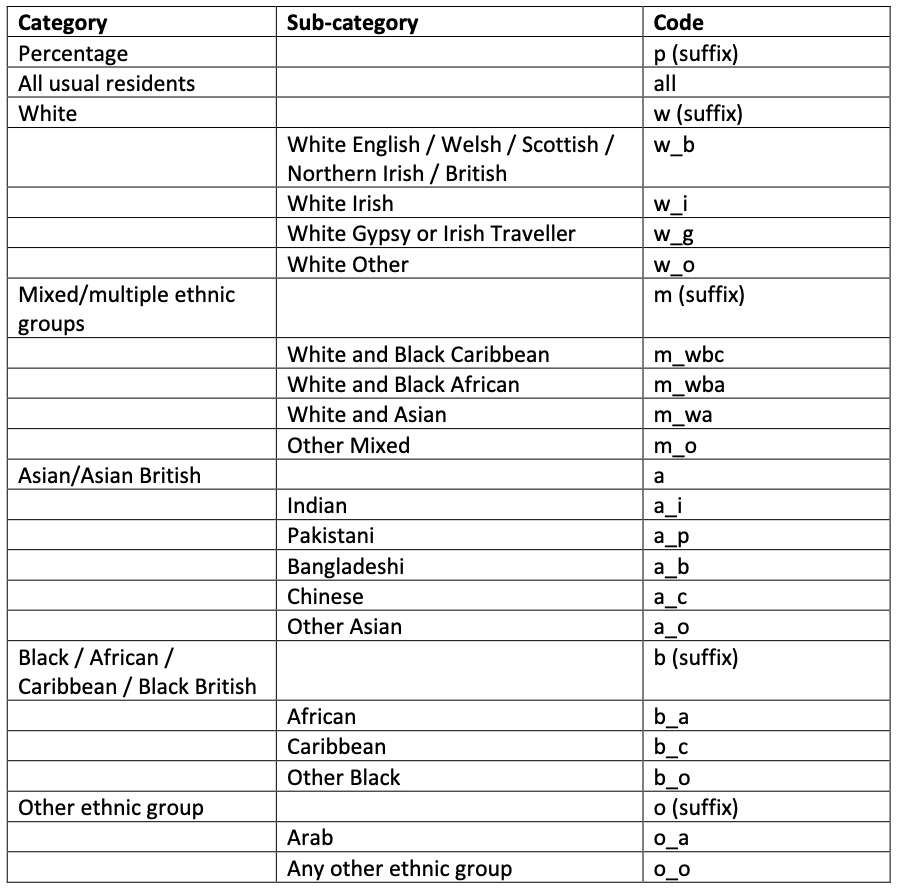

## Step 2 - Create population matrix

The `kl_divergence_profile` function pulls in a 'population matrix'.

This stems from the *basic_analysis.py* document - specifically the **`transform_population`** function from the **demographics** class.

This function is the first function from within the `Demographics` class - the command is from [this section of code](https://github.com/ceciledebezenac/segregation_index/blob/0e57b925450dad60e7cd9f987ba5ce499edccd8f/divergence/basic_analysis.py#L41-L46) - with the changes as follows:
- I have changed *'pop_matrix'* to *'leic_eth_population_matrix'* - to identify what it is I am working with here
- *'geodata'* is the *'leicester_ethnicity'* object we just read in
- *'groups'* is a list of the groups that you wish to include in your analysis

For ease, I will set this to the highest set of ethnicity classifications - as can be seen in the codebook included in Step 1 (see the first column).

These are: White (w), Mixed (m), Asian (a), Black (b) and Other (o)

First, the 'geodata' call must be set to read in our 'leicester_ethnicity' object.

The groups it draws in must also be set to the ones listed above.

In [52]:
geodata = leicester_ethnicity

groups = ['w', 'm', 'a', 'b', 'o']

The function takes the geodatabase input and subsets the chosen groups, converting it into an array

However, this the groups input is fed into a pre-prepared array of zeros - to avoid any issues with missing values.

The array of zeroes is setup using this command (with `len` ensuring it is of the right size):

In [53]:
leic_eth_population_matrix = np.zeros((len(geodata),len(groups)))

A loop is then used to input the data from our *leicester_ethnicity* object

In [54]:
for j in range (len(groups)):
    leic_eth_population_matrix[:,j] = list(map(float, geodata[groups[j]]))

The population matrix can then be viewed - the first row represents the top row of data. This can be seen in step 1 as the observation with the *oa11cd* of **E00068657**.

It shows that this output area has:
* 359 white residents
* 11 mixed residents
* 25 asian residents
* 18 black residents
* 0 other residents

In [55]:
leic_eth_population_matrix

array([[359.,  11.,  25.,  18.,   0.],
       [248.,  25.,  50.,  35.,   1.],
       [273.,  12.,  28.,   6.,  15.],
       ...,
       [129.,  12.,  73.,  23.,   4.],
       [ 72.,  19., 250.,  29.,  16.],
       [335.,  26., 171.,  53.,  12.]])

## Step 3 - Create q and r objects

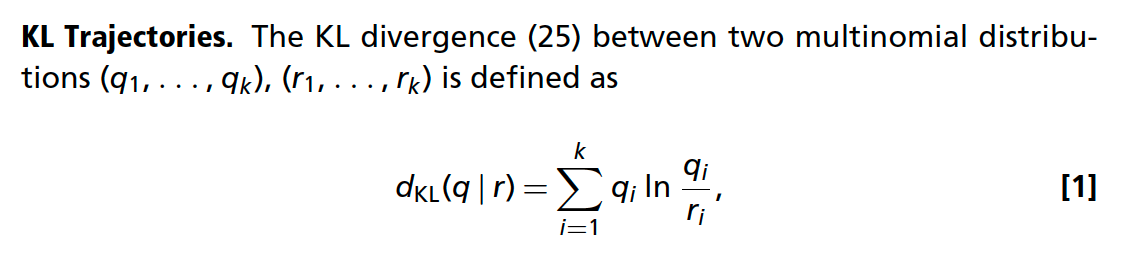

In the equation for KL divergence - taken from Olteanu et al (2019) see equation above - q and r are two multinomial distributions.

In Cécile's code, these objects are represented in the form of:
- **q = cumul_proportions** - at each observation, the proportion of each culmulative group out of the culmulative total population
- **r = ordered_proportions** - the proportions (percentages) of each group represented in the data, placed into an ordered list

### `cumul_proportions` (q)
The code for this is eventually:

`cumul_proportions = cumul_pop / sum_cumul_pop[:,np.newaxis]`

Those objects need to be created first though.

#### `cumul_pop`
This command culmulates the data at the group level.

For example, as the first number in each list is the white count. The white count for the first 3 output areas as 359, 248 and 273:
* In row 1, the first number in the list is 359 (culmulative of observation number 1)
* In row 2, the first number in the list is 607 (culmulative of observation numbers 1 and 2, i.e 359 + 248)
* In row 3, the first number in the list is 880 (culmulative of observation numbers 1, 2 and 3, i.e 359 + 248 + 273)

In [56]:
cumul_pop = np.cumsum(leic_eth_population_matrix, axis=0)

cumul_pop

array([[3.59000e+02, 1.10000e+01, 2.50000e+01, 1.80000e+01, 0.00000e+00],
       [6.07000e+02, 3.60000e+01, 7.50000e+01, 5.30000e+01, 1.00000e+00],
       [8.80000e+02, 4.80000e+01, 1.03000e+02, 5.90000e+01, 1.60000e+01],
       ...,
       [1.66229e+05, 1.15350e+04, 1.22049e+05, 2.05030e+04, 8.54000e+03],
       [1.66301e+05, 1.15540e+04, 1.22299e+05, 2.05320e+04, 8.55600e+03],
       [1.66636e+05, 1.15800e+04, 1.22470e+05, 2.05850e+04, 8.56800e+03]])

#### `sum_cumul_populations`
This command culmulates the number of residents in each observation (output area).

For example, the first number in the list is 413 - this is the total number of residents in the first output area (i.e 359 + 11 + 25 + 18 + 0)

The second number in the list is 772 - which is 413 + 359. The total number of residents in the second output area is 359 (i.e 248 + 25 + 50 + 35 + 1)

In [57]:
sum_cumul_pop = np.sum(cumul_pop, axis=1)

sum_cumul_pop[:5]

array([ 413.,  772., 1106., 1386., 1706.])

This output can be then changed slightly using the `[:,np.newaxis]` code, which converts the `sum_cumul_pop` output so that the addition of each output area to the culmulation is placed on a new row.

This is useful when we put it all together - as shown below.

In [58]:
sum_cumul_pop[:,np.newaxis][:5]

array([[ 413.],
       [ 772.],
       [1106.],
       [1386.],
       [1706.]])

#### Putting it together
The command to bring this all together makes use of the `[:,np.newaxis]` command, to ensure that the number of rows in both datasets is the same - meaning that each group is compared against the respective total culmulative value.

Therefore, this command - `cumul_proportions` - is the proportion of each culmulative group out of the culmulative total population.

For example, the first row of data is:

* $0.8692$ = $359 \over 413$ = $culmulative \space white \over culmulative \space total$


* $0.0266$ = $11 \over 413$ = $culmulative \space mixed \over culmulative \space total$


* $0.0605$ = $25 \over 413$ = $culmulative \space asian \over culmulative \space total$


* $0.0435$ = $18 \over 413$ = $culmulative \space black \over culmulative \space total$


* $0$ = $0 \over 413$ = $culmulative \space other \over culmulative \space total$

The second row of data is:

* $0.7862$ = $607 \over 772$ = $culmulative \space white \over culmulative \space total$


* $0.0466$ = $36 \over 772$ = $culmulative \space mixed \over culmulative \space total$


* $0.0971$ = $75 \over 772$ = $culmulative \space asian \over culmulative \space total$


* $0.0686$ = $53 \over 772$ = $culmulative \space black \over culmulative \space total$


* $0.0012$ = $1 \over 772$ = $culmulative \space other \over culmulative \space total$

And so on

In [43]:
cumul_proportions = cumul_pop / sum_cumul_pop[:,np.newaxis]

cumul_proportions

array([[0.86924939, 0.02663438, 0.06053269, 0.04358354, 0.        ],
       [0.78626943, 0.04663212, 0.09715026, 0.06865285, 0.00129534],
       [0.79566004, 0.04339964, 0.09312839, 0.05334539, 0.01446655],
       ...,
       [0.50547656, 0.03507614, 0.37113205, 0.06234644, 0.02596881],
       [0.50510263, 0.03509273, 0.37145625, 0.06236142, 0.02598696],
       [0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631]])

### `ordered_proportions`
This comes from the `theoretical_max_distortion` function - that is also within the *segregation_distortion.py* document

The code is:

`ordered_proportions=sorted(demographics.global_statistics)`

- The `global_statistics` object comes from the demographics class within the *basic_analysis.py* document
- It is created using `global_statistics = sum_pop_group/total_pop`

#### sum_pop_group and total_pop

So, looking firstly at the global statistics command - this uses two objects:
- `sum_pop_group` - this aggregates the total population of each group, using the population matrix we created in step 2. This can be seen below

This output is in the order white, mixed, asian, black and other

In [45]:
sum_pop_group = np.sum(leic_eth_population_matrix, axis=0)

sum_pop_group

array([166636.,  11580., 122470.,  20585.,   8568.])

- `total_pop` - again using our population matrix, this outputs the total population of our population matrix

i.e there are **329,839** people in Leicester, according to this record

In [46]:
total_pop = np.sum(leic_eth_population_matrix)

total_pop

329839.0

#### global_statistics

The `global_statistics` therefore represents the proportion of the population identified by each group

i.e according to this record, **50.52%** of Leicester's population are white

In [47]:
global_statistics = sum_pop_group/total_pop

global_statistics

array([0.50520405, 0.03510804, 0.37130236, 0.06240924, 0.02597631])

The **`ordered_proportions`** therefore take these proportions from `global_statistics` and put then in a sorted order.

As you can see from the output, they are sorted from a list array to one ascending column.

In [48]:
ordered_proportions = sorted(global_statistics)

ordered_proportions

[0.025976309654103972,
 0.035108037557717554,
 0.062409236021210346,
 0.37130236266784705,
 0.5052040540991211]

## Step 4 - Undertake the whole equation

To complete the whole equation - we need the to use **`cumul_proportions` (q)** and **`ordered_proportions` (r)** in an equation together to calculate the KL divergence profile. Within this equation is included a calculation of the natural logrithm of `cumul_proportions` divided by `ordered_proportions`.

$$ ln \left( {{q_i} \over {r_i}} \right) = ln \left( {{{{cumulative \_ proportions}\space_i}} \over {{ordered \_ proportions}\space_i}} \right) $$

In Cécile's code, this is done in two steps, in the following:

`relative_cumul_proportions = cumul_proportions / ordered_proportions`

`log_relative_cumul = np.log(relative_cumul_proportions)`

However, creating this calculation from scratch has issues in relation to this natural logarithms equation. Notably when dealing with zero values.

The natural logarithm of zero is approximated to negative infinity:

$$ln \left( 0 \right) \approx - \infty $$

Within a function - it is important that reponses you get are usable. Negative infinity is not in any way usable or useful to us, in relation to the population statistic we are trying to create.

In her code, Cécile resolves this mathematical quandry by including the following line of code within her function - substituting these negative infinity results with zero:

`log_relative_cumul[log_relative_cumul == -math.inf] = 0`

While this methodology is sound, I have been recommended to use the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function to carry out the whole equation listed on the Olteanu et al (2019) paper to calculate the KL divergence profile (which is also referred to as relative entropy). It takes in the *q* and *r* objects as an array, and returns the relative entropy.

Within the [reference material](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) for this function, you can see that the equation being calculated is exactly the same as in the Olteanu et al. paper - with the only extra functionality that if either $x = 0 \space \text{or} \space y = 0$ then the 'relative entropy' returned is 0, which resolves the issue of our equation outputting negative infinity.

For this to be useful in calculating a divergence profile, I first need to be able to sort the geographical units in terms of their proximity to some chosen central point for the analysis. To do this, I can first use the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) function to add a column of distance between each geographical unit and the chosen central point. I can then sort the geographical units with repect to this distance, and will be able to complete this KL divergence profile with respect to proximity.

### Using `scipy.spatial.distance_matrix`
As stated above, I can use the [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance_matrix.html) to create a matrix of the distances between each point.

In my context, this is incredibly useful for being able to find the calculate the distances between all of the Output Areas (OAs). I can then undertake the divergence profile on the data, when ordered by proximity to one of these OAs, and hence have a spatially-relevant KL divergence profile.

Given that I currently have the location information of OAs as their whole geometry, I first need to create coordinates as a point of reference, from which to measure this distance.

To do this, I am going to find the [centroid](https://en.wikipedia.org/wiki/Centroid) (central point - or arithmetic mean of points) of each OA, using the *geopandas* [`GeoSeries.centroid`](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.centroid.html) command.

This has then been saved as **oa_centroids**

In [61]:
oa_centroids = leicester_ethnicity.geometry.centroid

oa_centroids

0      POINT (458352.490 307530.587)
1      POINT (458781.908 307161.265)
2      POINT (458530.851 307158.333)
3      POINT (458132.269 306870.034)
4      POINT (458905.416 306739.221)
                   ...              
964    POINT (456480.951 306507.987)
965    POINT (461943.370 305928.943)
966    POINT (458277.707 303907.173)
967    POINT (461583.353 306057.348)
968    POINT (458198.005 303928.443)
Length: 969, dtype: geometry

GeoSeries objects are a little difficult to index (extract information from). You can see that each 'POINT' has two distinct values, that represent the coordinates of the central point of each OA. To make them easy to use, I would prefer this information to be in an array, with one column representing the latitude and longitude (x and y) of each centroid.

Fortunately, an object created using `centroid` can have its coordinates plucked out using the `.x` and `.y` functionality. You can see that the code below outputs the x coordinate (left hand column) for observation with the index of 0 (the first observation/row of the oa_centroids object).

In [41]:
oa_centroids.x[0]

458352.4896059748

Therefore, using the `np.column_stack` command, I can assign a two column array to output the coordinates of the centroids of each OA.

In [60]:
oa_coords = np.column_stack((oa_centroids.x, oa_centroids.y))

oa_coords

array([[458352.48960597, 307530.58680903],
       [458781.90779248, 307161.26530351],
       [458530.85131285, 307158.33311064],
       ...,
       [458277.70694466, 303907.17345114],
       [461583.3532046 , 306057.34838906],
       [458198.00466388, 303928.44310561]])

Finally, I can now get around to using the `distance_matrix` command, to calculate the '[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)' (straight-line distance, Pythagorean distance, call it what you want) between the centroid of each and every OA in Leicester! I have input the *oa_coords* object into this command twice because I want to measure the distance between each OA and every other OA, this object contains the beginning and end of each distance measurement.

As a result of this input, you will be able to see zero values within the *oa_d_matrix* object - which represent the distance measured between each centroid and itself.

This gives you an idea of how this function is operating, iterating through each point, first measuring the distance between point 0 on input 1 (oa_coords) and and point 0 on input 2 (also oa_coords). Hence why the first value of the first row of the output is 0.

The function has then measured the distance between point 0 on input 1 to point 1 on input 2, which is measured as *566.39...* units. This can be seen on the second value of the first row. But, it can be also seen on the first value of the second row, which represents the distance measured between point 1 on input 1 and point 0 on input 2. As both the inputs are the same, you will be able to see these mirrored/duplicated figures throughout the dataset. It is good news they are present, and shows you that the command is working as it should.

In [67]:
oa_d_matrix = distance_matrix(oa_coords, oa_coords)

oa_d_matrix

array([[   0.        ,  566.3906367 ,  412.77804501, ..., 3624.18498542,
        3550.90284787, 3605.45487525],
       [ 566.3906367 ,    0.        ,  251.07360219, ..., 3292.92154151,
        3011.10095332, 3285.13047334],
       [ 412.77804501,  251.07360219,    0.        , ..., 3261.00003108,
        3244.98615656, 3246.99497018],
       ...,
       [3624.18498542, 3292.92154151, 3261.00003108, ...,    0.        ,
        3943.41849916,   82.4915254 ],
       [3550.90284787, 3011.10095332, 3244.98615656, ..., 3943.41849916,
           0.        , 3999.10270537],
       [3605.45487525, 3285.13047334, 3246.99497018, ...,   82.4915254 ,
        3999.10270537,    0.        ]])

Below I have selected the first 24 distance measurements from point 0 in *oa_coords* - it is clear that they have not been ordered, but instead represent the distance between the first point of input 1 and first 24 points from input 2.

In [70]:
oa_d_matrix[0,:24]

array([   0.        ,  566.3906367 ,  412.77804501,  696.29514464,
        965.39546449, 1033.10512064, 1211.53527928,  913.74252203,
       1291.78393035,  852.15070031,  415.4250758 ,  920.56203678,
        418.23274714,  455.00643148,  659.74227111,  732.99644795,
        201.02294776,  196.45014637,  569.68086007,  428.43385495,
        217.40594256,  460.43741361,   99.84874874])

I now need to establish a methodology for sorting the output of the distance matrix, such that I can create a proximity-ordered input for the KL divergence equation.

The `argsort` function from the *NumPy* library is able to do what I want. However, you will note that where I have inputted the distance measurements from point 0 (hence the *[0]*) that the *sorted_indices_obs0* output does not return an ordered array of the distance values, but instead returning the indices (position in the array) that corresponds to the increasing distance values.

Below you can see that the `argsort` function establishes that the lowest value in *oa_d_matrix* is observation 0 - which corresponds to the distance between point 0 and itself - so far so good. The second lowest value - which corresponds to the OA with the closest centroid to point 0 - is found at observation 22.

So the OA represented by observation 22 is the closest OA to our reference OA, point 0. Then, the second closest OA is observation 17, third closest is observation 16, and so on.

In [85]:
sorted_indices_obs0 = np.argsort(oa_d_matrix[0])

sorted_indices_obs0[:20]

array([ 0, 22, 17, 16, 20, 26, 24,  2, 25, 10, 12, 19, 13, 21, 23,  1, 18,
       29, 42, 40])

I can test out the output of `argsort` by indexing (pulling out) the distance figures represented from the observations it lists as closest to point 0.

Below you can see that:
- Observation 22 is listed as *99.84...* units from point 0
- Observation 17 is listed as *196.45...* units from point 0
- Observation 16 is listed as *201.02...* units from point 0
- Observation 20 is listed as *217.40...* units from point 0

So it seems that `argsort` has done its job - we have a way of finding the closest OAs to our reference of point 0.

In [82]:
oa_d_matrix[0, [0, 22, 17, 16, 20]]

array([  0.        ,  99.84874874, 196.45014637, 201.02294776,
       217.40594256])

To do the previous step in a more efficient way, we can input our *sorted_indices_obs0* as the indexing input. This saves us writing them all out by hand. Here I've selected the first 20.

In [86]:
oa_d_matrix[0, sorted_indices_obs0][:20]

array([  0.        ,  99.84874874, 196.45014637, 201.02294776,
       217.40594256, 325.55581094, 359.75156182, 412.77804501,
       413.75356582, 415.4250758 , 418.23274714, 428.43385495,
       455.00643148, 460.43741361, 565.86062144, 566.3906367 ,
       569.68086007, 576.47296505, 640.02582031, 649.92765025])

But what if I want to know the distances from a different OA? Well I can actually get to our ordered distances matrix in one line of code, by combining all of our previous steps together.

Instead of point 0 in our first example, lets choose a completely random number to look at... point 425 in the observed OAs.

To find our distance matrix, you can do the following:

In [87]:
oa_d_matrix[425, np.argsort(oa_d_matrix[425])][:20]

array([  0.        , 202.47326134, 205.10376477, 260.76175512,
       311.23760685, 312.45522627, 322.11656464, 350.87726699,
       364.41809331, 424.00049742, 425.78792883, 430.05702551,
       447.64502897, 477.63295736, 481.71413063, 517.04595294,
       543.67952058, 577.06157476, 599.61158882, 600.00705389])

This therefore tells us that - for point 425:
- The closest OA is *202.47...* units away
- The second closest OA is *205.10...* units away
- The third closest OA is *260.76...* units away

## Still to come

I then need to input this into the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function. and this notebook will be updated in due course with the code required to facilitate the calculation of a KL divergence profile.